Este projeto destina-se a criar um sistema de detecção de fraude utilizando machine learning. Para isso, será utilizada uma base de dados do Kaggle chamada [Fraud Detection Example] (https://www.kaggle.com/gopalmahadevan/fraud-detection-example) e ela tem uma fração de dados do [PaySim](https://github.com/EdgarLopezPhD/PaySim), um simulador de dados financeiros feito exatamente para detecção de fraude.

**Colunas do dataset**

**step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
(caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência)

**amount** - valor da transação em moeda local.

**nameOrig** - cliente que iniciou a transação

**oldbalanceOrg** - saldo inicial antes da transação

**newbalanceOrig** - novo saldo após a transação

**nameDest** - cliente que é o destinatário da transação

**oldbalanceDest** - destinatário do saldo inicial antes da transação. 
Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest** - novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud** - São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

**isFlaggedFraud** - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.


# Imports

In [70]:
# data wrangling
import pandas as pd
import pandas_profiling
import numpy as np

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# data balancing
from imblearn.over_sampling import SMOTE

# Get Data

In [2]:
df = pd.read_csv('fraud_dataset_example.csv')

In [3]:
df

step      type      amount     nameOrig  oldbalanceOrg  \
0          1   PAYMENT     9839.64  C1231006815      170136.00   
1          1   PAYMENT     1864.28  C1666544295       21249.00   
2          1  TRANSFER      181.00  C1305486145         181.00   
3          1  CASH_OUT      181.00   C840083671         181.00   
4          1   PAYMENT    11668.14  C2048537720       41554.00   
...      ...       ...         ...          ...            ...   
101608    10   PAYMENT     7477.02   C513257306         785.00   
101609    10  CASH_OUT   282252.35   C210473293      220339.29   
101610    10   PAYMENT    17289.01   C807582280           0.00   
101611    10  TRANSFER  1347146.45  C1315779140        1605.00   
101612    10  CASH_OUT   469539.21   C515691325       31133.00   

        newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0            160296.36  M1979787155            0.00            0.00        0   
1             19384.72  M2044282225            0.00            0.00        0   
2                 0.00   C553264065            0.00            0.00        1   
3                 0.00    C38997010        21182.00            0.00        1   
4             29885.86  M1230701703            0.00            0.00        0   
...                ...          ...             ...             ...      ...   
101608            0.00   M524833426            0.00            0.00        0   
101609            0.00  C1172042998        95156.01        91286.97        0   
101610            0.00   M334249577            0.00            0.00        0   
101611            0.00  C1631408038       541639.43      2186953.43        0   
101612            0.00  C1383702768            0.00       469539.21        0   

        isFlaggedFraud  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
101608               0  
101609               0  
101610               0  
101611               0  
101612               0  

[101613 rows x 11 columns]

In [4]:
# vendo o nome das colunas
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Trazendo colunas de fraude para o começo do dataset

In [5]:
df = df[['isFraud','isFlaggedFraud', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']]
df.head()

isFraud  isFlaggedFraud  step      type    amount     nameOrig  \
0        0               0     1   PAYMENT   9839.64  C1231006815   
1        0               0     1   PAYMENT   1864.28  C1666544295   
2        1               0     1  TRANSFER    181.00  C1305486145   
3        1               0     1  CASH_OUT    181.00   C840083671   
4        0               0     1   PAYMENT  11668.14  C2048537720   

   oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  
0       170136.0       160296.36  M1979787155             0.0             0.0  
1        21249.0        19384.72  M2044282225             0.0             0.0  
2          181.0            0.00   C553264065             0.0             0.0  
3          181.0            0.00    C38997010         21182.0             0.0  
4        41554.0        29885.86  M1230701703             0.0             0.0

# Renomeando as colunas

In [6]:
# Criando o dicionário com as colunas
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

In [7]:
# renomeando colunas
df = df.rename(columns = colunas)
df.head()

fraude  super_fraude  tempo      tipo     valor     cliente1  \
0       0             0      1   PAYMENT   9839.64  C1231006815   
1       0             0      1   PAYMENT   1864.28  C1666544295   
2       1             0      1  TRANSFER    181.00  C1305486145   
3       1             0      1  CASH_OUT    181.00   C840083671   
4       0             0      1   PAYMENT  11668.14  C2048537720   

   saldo_inicial_c1  novo_saldo_c1     cliente2  saldo_inicial_c2  \
0          170136.0      160296.36  M1979787155               0.0   
1           21249.0       19384.72  M2044282225               0.0   
2             181.0           0.00   C553264065               0.0   
3             181.0           0.00    C38997010           21182.0   
4           41554.0       29885.86  M1230701703               0.0   

   novo_saldo_c2  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

# Outras informações do dataset

In [8]:
# analisando estatísticas das variáveis numéricas
df.describe().round(2).T

count        mean         std   min       25%       50%  \
fraude            101613.0        0.00        0.03  0.00      0.00      0.00   
super_fraude      101613.0        0.00        0.00  0.00      0.00      0.00   
tempo             101613.0        8.52        1.82  1.00      8.00      9.00   
valor             101613.0   174090.07   345019.90  0.32  10016.59  53385.41   
saldo_inicial_c1  101613.0   907175.26  2829575.28  0.00      0.00  20190.47   
novo_saldo_c1     101613.0   923499.25  2867318.71  0.00      0.00      0.00   
saldo_inicial_c2  101613.0   881042.80  2399949.06  0.00      0.00  21058.00   
novo_saldo_c2     101613.0  1183998.10  2797761.08  0.00      0.00  51783.43   

                         75%          max  
fraude                  0.00         1.00  
super_fraude            0.00         0.00  
tempo                  10.00        10.00  
valor              212498.40  10000000.00  
saldo_inicial_c1   194715.00  38939424.03  
novo_saldo_c1      219217.76  38946233.02  
saldo_inicial_c2   591921.70  34008736.98  
novo_saldo_c2     1063121.64  38946233.02

In [9]:
df.shape

(101613, 11)

In [10]:
# verificando se há dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fraude            101613 non-null  int64  
 1   super_fraude      101613 non-null  int64  
 2   tempo             101613 non-null  int64  
 3   tipo              101613 non-null  object 
 4   valor             101613 non-null  float64
 5   cliente1          101613 non-null  object 
 6   saldo_inicial_c1  101613 non-null  float64
 7   novo_saldo_c1     101613 non-null  float64
 8   cliente2          101613 non-null  object 
 9   saldo_inicial_c2  101613 non-null  float64
 10  novo_saldo_c2     101613 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


# Verificando a variável target

In [11]:
df2 = df.groupby(by = 'fraude').agg({'tempo':'count'}).reset_index()

# Calculating Percentage
df2['percent'] = ((df2['tempo'] / 
                  df2['tempo'].sum()) * 100).round(2)
df2.head()

fraude   tempo  percent
0       0  101497    99.89
1       1     116     0.11

Apenas 0.11% dos dados da base advém de fraudes.

# Encoding

In [12]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Encoding

In [13]:
# transformando a coluna categórica de tipo em colunas com variáveis numéricas
df = pd.get_dummies(data = df, columns = ['tipo'])

In [14]:
df.head()

fraude  super_fraude  tempo     valor     cliente1  saldo_inicial_c1  \
0       0             0      1   9839.64  C1231006815          170136.0   
1       0             0      1   1864.28  C1666544295           21249.0   
2       1             0      1    181.00  C1305486145             181.0   
3       1             0      1    181.00   C840083671             181.0   
4       0             0      1  11668.14  C2048537720           41554.0   

   novo_saldo_c1     cliente2  saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  \
0      160296.36  M1979787155               0.0            0.0             0   
1       19384.72  M2044282225               0.0            0.0             0   
2           0.00   C553264065               0.0            0.0             0   
3           0.00    C38997010           21182.0            0.0             0   
4       29885.86  M1230701703               0.0            0.0             0   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0              0           0             1              0  
1              0           0             1              0  
2              0           0             0              1  
3              1           0             0              0  
4              0           0             1              0

# Removendo variáveis

Não houve nenhuma super fraude, logo, essa coluna deve ser removida.

In [15]:
df = df.drop(columns = ['cliente1', 'cliente2', 'super_fraude'])

In [16]:
df.head()

fraude  tempo     valor  saldo_inicial_c1  novo_saldo_c1  saldo_inicial_c2  \
0       0      1   9839.64          170136.0      160296.36               0.0   
1       0      1   1864.28           21249.0       19384.72               0.0   
2       1      1    181.00             181.0           0.00               0.0   
3       1      1    181.00             181.0           0.00           21182.0   
4       0      1  11668.14           41554.0       29885.86               0.0   

   novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  \
0            0.0             0              0           0             1   
1            0.0             0              0           0             1   
2            0.0             0              0           0             0   
3            0.0             0              1           0             0   
4            0.0             0              0           0             1   

   tipo_TRANSFER  
0              0  
1              0  
2              1  
3              0  
4              0

# Regressão Logística

In [17]:
# dividindo o dataframe e a variável target
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [18]:
# dividindo entre dados de treino e dados de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [19]:
# instanciando o modelo de regressão logística
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# treinando o modelo
lr.fit(x_train, y_train)
# definindo a predição
y_pred = lr.predict(x_test)

# Métricas do modelo

In [20]:
# analisando a acurácia (avalia a quantidade de acertos)
print('Acurácia: {}'.format(metrics.accuracy_score(y_test, y_pred)))
# analisando a precisão (quantidade de verdadeiros positivos, quantas fraudes ocorrem)
print('Precisão: {}'.format(metrics.precision_score(y_test, y_pred)))
# analisando o recall (avalia a capacidade do modelo classificar corretamente as classes)
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
# analisando o F1 score (media harmônica entre a precisão e o recall)
print('F1 Score: {}'.format(metrics.f1_score(y_test, y_pred)))

Acurácia: 0.9989765391276965
Precisão: 0.2
Recall: 0.043478260869565216
F1 Score: 0.07142857142857142


# Matriz de confusão

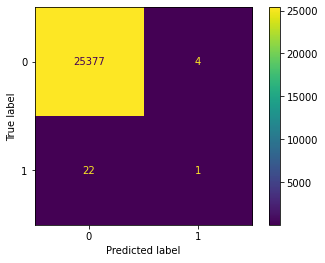

In [21]:
# criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# plottando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

As classes estão desbalanceadas, pois há muito mais dados em uma classe (daqueles que não realizaram fraude) em comparação as ocorrências de fraude.

# Curva ROC

In [22]:
# instanciando as métricas da curva ROC
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

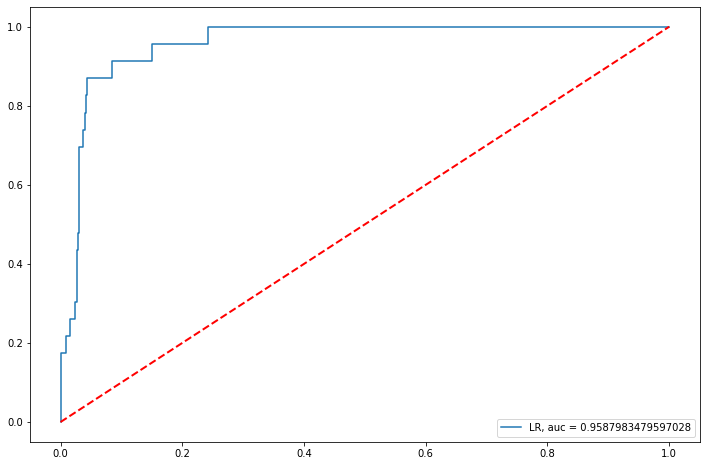

In [23]:
# plottando
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)

A curva ROC mostra que as classes estão desbalanceadas pois a acurácia está muito alta, porém as outras métricas estão baixíssimas. Será preciso balancear o dataset.

# Balanceamento dos dados

In [24]:
# instanciando o smote
smote = SMOTE(random_state = 42)

In [25]:
# retirando a variável target do dataframe
x = df.drop(columns = ['fraude'])
y = df['fraude']

In [26]:
# criando variáveis balanceadas
x_resampled, y_resampled = smote.fit_resample(x, y)

In [27]:
# unindo as partes resampled em um único dataframe
df_balanced = pd.concat([y_resampled, x_resampled], axis = 1)

In [28]:
df_balanced

fraude  tempo          valor  saldo_inicial_c1  novo_saldo_c1  \
0            0      1    9839.640000     170136.000000      160296.36   
1            0      1    1864.280000      21249.000000       19384.72   
2            1      1     181.000000        181.000000           0.00   
3            1      1     181.000000        181.000000           0.00   
4            0      1   11668.140000      41554.000000       29885.86   
...        ...    ...            ...               ...            ...   
202989       1      5   17608.962863      17608.962863           0.00   
202990       1      7   12116.291013      12116.291013           0.00   
202991       1      1  231612.880715     231612.880715           0.00   
202992       1      9  547325.144758     547325.144758           0.00   
202993       1      4  159298.594420     159298.594420           0.00   

        saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  \
0               0.000000       0.000000             0              0   
1               0.000000       0.000000             0              0   
2               0.000000       0.000000             0              0   
3           21182.000000       0.000000             0              1   
4               0.000000       0.000000             0              0   
...                  ...            ...           ...            ...   
202989          0.000000       0.000000             0              0   
202990          0.000000       0.000000             0              0   
202991       1945.589357    9370.603471             0              0   
202992          0.000000       0.000000             0              0   
202993          0.000000       0.000000             0              0   

        tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0                0             1              0  
1                0             1              0  
2                0             0              1  
3                0             0              0  
4                0             1              0  
...            ...           ...            ...  
202989           0             0              1  
202990           0             0              1  
202991           0             0              0  
202992           0             0              1  
202993           0             0              1  

[202994 rows x 12 columns]

In [29]:
df_balanced.groupby(by = 'fraude').agg({'tempo':'count'})

tempo
fraude        
0       101497
1       101497

Agora a label target está balanceada.

# Novo teste da Regressão Logística

In [30]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)

lr = LogisticRegression(max_iter=1000, random_state = 42)

lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


Embora a acurácia tenha diminuído, as outras métricas aumentaram bastante, tornando assim o resultado mais confiável.

# Matriz de confusão e curva ROC para o modelo com dados balanceados

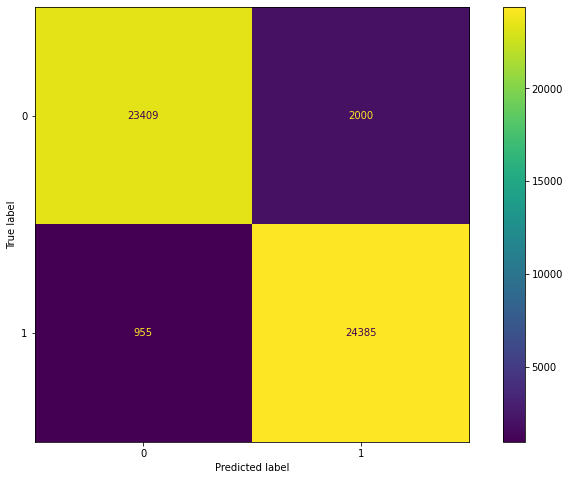

In [32]:
# criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# plottando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

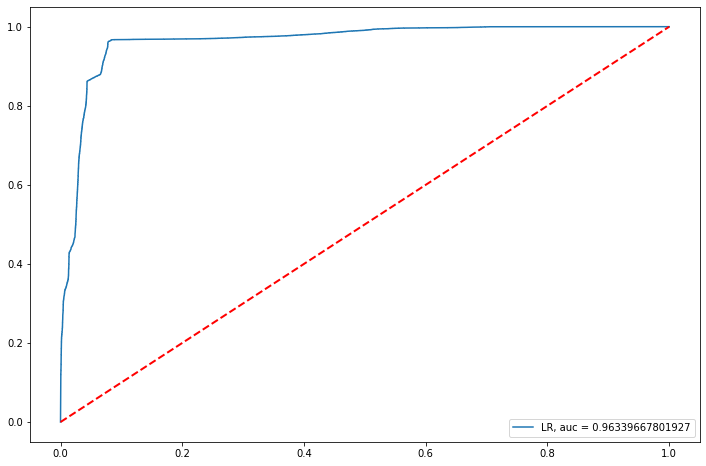

In [33]:
# instanciando as métricas da curva ROC
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plottando
plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr, tpr, label = 'LR, auc = ' + str(auc))
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--')
plt.legend(loc = 4)

# Formulando hipóteses sobre as fraudes

In [34]:
pandas_profiling.ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Com o dataset balanceado, nota-se que as variáveis tempo, novo_saldo_1, cash_in, payment e transfer estão altamente correlacionadas com a fraude.

* Hipótese 1: O tipo payment é o que a pessoa utiliza como padrão e a fraude ocorre pelo tipo transfer.

* Hipótese 2: O cliente pode fazer seus pagamentos durante um período do dia e a fraude ocorre em períodos diferentes.

* Hipótese 3: O cliente paga as suas contas no início do mês e houve movimentações no final do mês, sendo uma fraude.

# Decision Tree

Criando mais modelos comparativos com a regressão logística

In [47]:
# instanciando a decision tree
dt =  DecisionTreeClassifier(max_depth = 5, random_state = 42)

In [48]:
# treinando a decision tree
model = dt.fit(x_train, y_train)
# obtendo as previsões
y_pred = dt.predict(x_test)

In [49]:
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


# Matriz de confusão para a decision tree

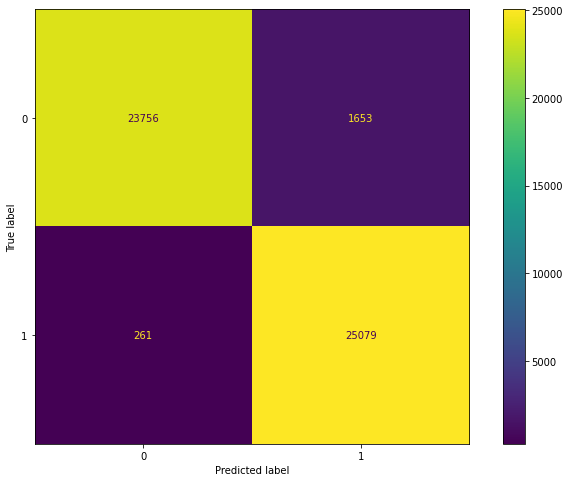

In [50]:
# criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
# plottando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Os resultados estão melhores que utilizando a regressão logística.

# Curva ROC para a decision tree

Text(0.5, 1.0, 'Curva ROC para a Decision Tree')

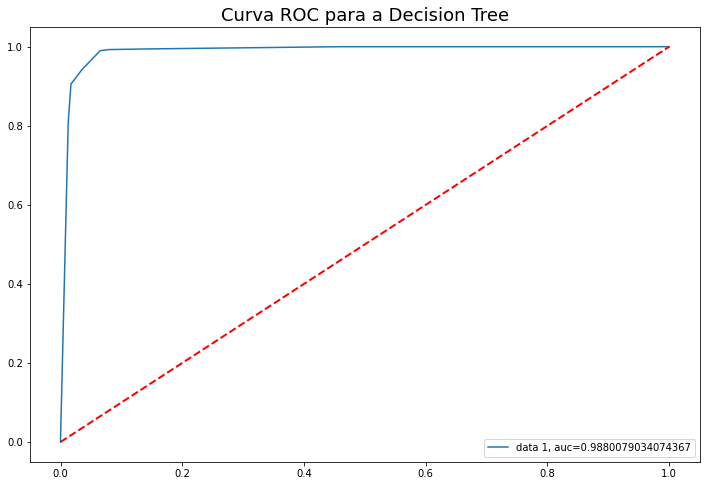

In [62]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title('Curva ROC para a Decision Tree', fontsize = 18)

# Random Forest

In [55]:
# instanciando a random forest
rf = RandomForestClassifier(max_depth = 5, random_state = 42)

In [56]:
# treinando o modelo
model = rf.fit(x_train, y_train)
# obtendo as predições
y_pred = rf.predict(x_test)

# Métricas da Random Forest

In [57]:
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


# Matriz de confusão para a Random Forest

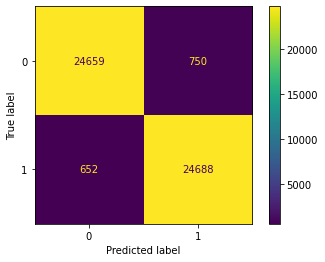

In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Os resultados com a random forest mostraram-se ainda melhores que a decision tree.

# Curva ROC para a Random Forest

Text(0.5, 1.0, 'Curva ROC para a Random Forest')

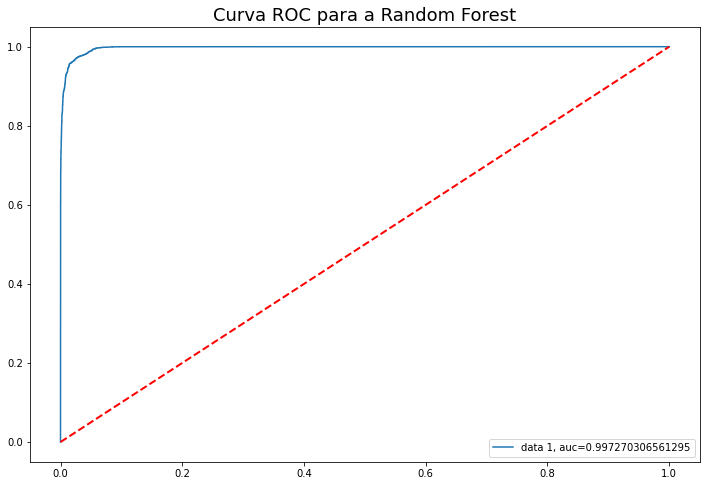

In [61]:
y_pred_proba =  rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)
plt.title('Curva ROC para a Random Forest', fontsize = 18)

Dentre estes modelos, é preciso decidir qual modelo será utilizado e como melhorá-lo.

# Análise das métricas dos modelos

In [65]:
# criando lista com todos os modelos com os seus hiperparâmetros
classifiers = [
    LogisticRegression(max_iter = 1000, random_state = 42),
    DecisionTreeClassifier(max_depth = 5, random_state = 42),
    RandomForestClassifier(max_depth= 5, random_state = 42)]

LogisticRegression
***Resultados***
Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975
DecisionTreeClassifier
***Resultados***
Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943
RandomForestClassifier
***Resultados***
Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


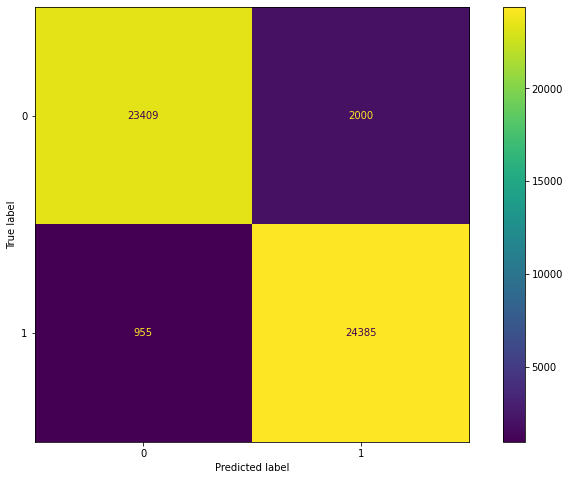

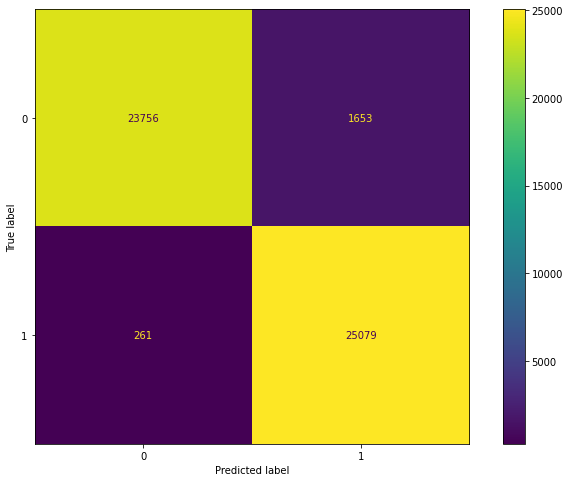

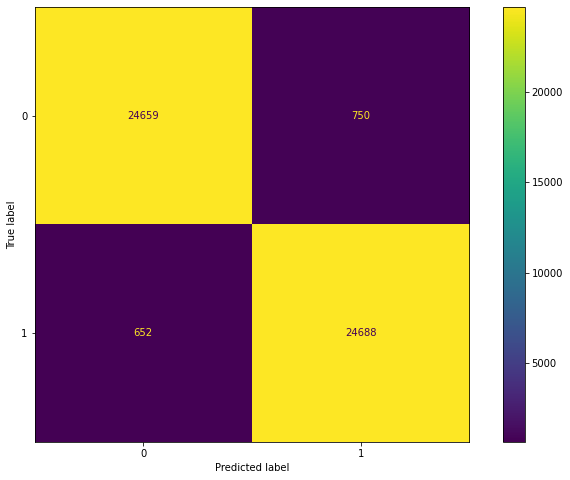

In [64]:
for clf in classifiers:
    # treinando os modelos
    clf.fit(x_train, y_train)
    # criando os nomes dos modelos com a visualização
    name = clf.__class__.__name__
    print('='*30)
    print(name)
    print('***Resultados***')
    # obtendo a predição de cada modelo
    y_pred = clf.predict(x_test)

    # métricas de cada modelo
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred))
    print("Recall:", metrics.recall_score(y_test, y_pred))
    print("F1:", metrics.f1_score(y_test, y_pred))

    # matrizes de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


A Random Forest mostrou-se o modelo com os melhores resultados. O próximo passo agora é melhorar os hyperparâmetros dele para que encontremos um resultado ainda melhor.

# Tunando os hyperparâmetros

Para descobrir quais são os melhores hyperparâmetros para o modelo, deve-se definir quais serão os parâmetros a serem variados.

In [88]:
# definindo o range de estimadores para ter de 20 a 2000 árvores
n_estimators = np.arange(20, 2000, step = 20)
# variando os critérios
criterion = ["gini", "entropy"]
# explorando os tipos de features
max_features = ["auto", "sqrt", "log2"]
# variando a profundidade da árvore 
max_depth = list(np.arange(2, 200, step = 1))
# variando a quantidade mínima pra separação
min_samples_split = np.arange(2, 100, step = 2)
# variando a quantidade minima de folhas
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# bootstrap para utilizar todo o conjunto de treinamento ou as amostras
bootstrap = [True, False]

In [89]:
# dicionário com os parâmetros a srem variados
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [90]:
# instanciando um random forest
rforest = RandomForestClassifier(random_state = 75)

In [91]:
# hyperparâmetros no randomized search cv
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter = 5, cv = 3, scoring = "recall", n_jobs = -1, random_state = 75
)

In [92]:
# fittando
rcv = random_cv.fit(x, y)

In [93]:
# criando um dataframe com os testes de hyperparâmetros
tuning = pd.DataFrame(rcv.cv_results_)

In [94]:
tuning

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     329.522300     37.904785         9.451478        0.663580   
1     221.133406     20.640209         8.086719        0.932036   
2     481.351833     50.093418        12.773433        0.950012   
3     924.192728     93.838212        17.583926        1.734405   
4     533.890549     57.548444        10.763773        1.106058   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                720                       4                      4   
1                600                      16                      2   
2               1080                      34                      1   
3               1660                      88                      6   
4                960                      70                      2   

  param_max_features param_max_depth param_criterion param_bootstrap  \
0               log2             120         entropy            True   
1               sqrt             172            gini            True   
2               sqrt             115         entropy            True   
3               log2              52         entropy           False   
4               auto             100         entropy           False   

                                              params  split0_test_score  \
0  {'n_estimators': 720, 'min_samples_split': 4, ...           0.999320   
1  {'n_estimators': 600, 'min_samples_split': 16,...           0.999261   
2  {'n_estimators': 1080, 'min_samples_split': 34...           0.999261   
3  {'n_estimators': 1660, 'min_samples_split': 88...           0.999291   
4  {'n_estimators': 960, 'min_samples_split': 70,...           0.999261   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.999970           0.999734         0.999675        0.000269   
1           0.999941           0.999675         0.999626        0.000280   
2           0.999941           0.999616         0.999606        0.000278   
3           0.999941           0.999468         0.999566        0.000274   
4           0.999941           0.999557         0.999586        0.000278   

   rank_test_score  
0                1  
1                2  
2                3  
3                5  
4                4

In [95]:
rcv.best_params_

{'n_estimators': 720,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 120,
 'criterion': 'entropy',
 'bootstrap': True}

Estes foram os melhores parâmetros escolhidos para maximizar o recall do modelo.

# Aplicando parâmetros no Random Forest

In [96]:
# instanciando o random forest
rfn = RandomForestClassifier(**rcv.best_params_, random_state = 75)

# treinando o modelo
model = rfn.fit(x_train, y_train)
# valores preditos
y_pred = rfn.predict(x_test)

# Avaliação das Métricas

In [97]:
# métricas
print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9990935781985852
Precisão: 0.99850216791486
Recall: 0.9996842936069456
F1: 0.9990928810885427


# Matriz de confusão para o Random Forest tunado

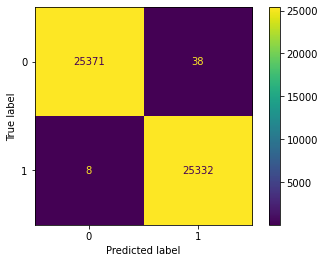

In [98]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Estes são os melhores resultados possíveis para o modelo, criando assim o modelo de detecção de fraude. Agora há somente 7 falsos positivos e 65 falsos negativos.

# Solução do negócio

* 1: O(a) cliente tem um certo padrão de movimentação do dinheiro, em horário comercial, e a fraude ocorreu fora deste horário, como por exemplo durante a madrugada. Ainda em relação ao tempo, o cliente pode fazer suas principais movimentações em um período inicial do mês e a fraude foi vista em um dia não habitual.

Solução:  - Fazer um CAPTCHA para aumentar a segurança em horários não convencionais.

* 2: O(a) cliente utiliza como padrão o pagamento em dinheiro, seja por PIX ou retirada*, e a fraude pode ocorrer por um pagamento por transferência.

- Solução: Solicitar uma verificação de informação adicional do banco, como uma pergunta de segurança, para movimentações de transferência.